In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 294 kB 8.0 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statannotations 0.6.0 requires seaborn<0.12,>=0.9.0, but you have seaborn 0.13.0 which is incompatible.


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
virprobert_output_auprc_file_paths =  {
    #"unseen_hosts": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241001/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk10e1b32itr1_split70-10-20-gpu2_wo_non_idv_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "unseen_hosts_with_non_idv_wo_human": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_seen_hosts/20241001/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk10e1b32itr1_split70-10-20-gpu2_wo_human_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    #"sl256st64_w5s2": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240906/host_multi/few_shot_learning/fsl_tr_w5s2q10_te_w5s2q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
}
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")

In [5]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    print(labels_counts)
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n(n={int(v/100*n)}, {v:.3f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [6]:
df = read_output_df(virprobert_output_auprc_file_paths)
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
df.shape

(1470, 4)

In [8]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=True)
metadata_formatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 'Homo sapiens\n(n=218631, 99.347%)',
 'Macaca mulatta': 'Macaca mulatta\n(n=849, 0.386%)',
 'Felis catus': 'Felis catus\n(n=143, 0.065%)',
 'Cercocebus atys': 'Cercocebus atys\n(n=122, 0.055%)',
 'Puma concolor': 'Puma concolor\n(n=24, 0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(n=23, 0.010%)',
 'Mandrillus sphinx': 'Mandrillus sphinx\n(n=23, 0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(n=20, 0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(n=19, 0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(n=17, 0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(n=16, 0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(n=14, 0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(n=13, 0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(n=13, 0.006%)',
 'Colobus guereza': 'Colobus guereza\n(n=13, 0.006%)',
 'Panthera leo': 'Panthera leo\n(n=12, 0.005%)',
 'Cercopithecus neglectus': 'Cercopithecus neg

In [9]:
dataset_df["virus_host_name"].nunique()

40

In [10]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=False)
metadata_unformatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 99.34702001199629,
 'Macaca mulatta': 0.3857898467746333,
 'Felis catus': 0.0649799152989076,
 'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus sphinx': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Cercopithecus cephus': 0.005907265027173419,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Colobus guereza': 0.005907265027173419,
 'Panthera leo': 0.005452860025083156,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Cercopithecus mona': 0.0045440500209026295,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopit

In [11]:
# Retain only the hosts from the idv dataset
df = df[df["class"].isin(metadata_unformatted.keys())]

In [12]:
df["class"].nunique()

7

In [13]:
df["prevalence"] = df["class"].apply(lambda x: metadata_unformatted[x])
df

,class,auprc,itr,model,prevalence
18,Bos taurus,0.028634,0,unseen_hosts_with_non_idv_wo_human,0.001818
47,Felis catus,0.216775,0,unseen_hosts_with_non_idv_wo_human,0.064980
48,Felis domesticus,0.045172,0,unseen_hosts_with_non_idv_wo_human,0.002272
69,Macaca arctoides,0.083898,0,unseen_hosts_with_non_idv_wo_human,0.002272
70,Macaca fascicularis,0.017534,0,unseen_hosts_with_non_idv_wo_human,0.002272
...,...,...,...,...,...
1371,Felis domesticus,0.156829,0,unseen_hosts_with_non_idv_wo_human,0.002272
1392,Macaca arctoides,0.047486,0,unseen_hosts_with_non_idv_wo_human,0.002272
1393,Macaca fascicularis,0.018432,0,unseen_hosts_with_non_idv_wo_human,0.002272
1395,Macaca mulatta,0.689325,0,unseen_hosts_with_non_idv_wo_human,0.385790


In [14]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus sphinx',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Cercopithecus cephus',
 'Chlorocebus sabaeus',
 'Colobus guereza',
 'Panthera leo',
 'Cercopithecus neglectus',
 'Cercopithecus mona',
 'Chlorocebus tantalus',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Cercopithecus erythrotis',
 'Felis domesticus',
 'Macaca arctoides',
 'Macaca fascicularis',
 'Semnopithecus entellus',
 'Bos taurus',
 'Miopithecus ogouensis',
 'Cercopithecus ascanius',
 'Cercocebus torquatus atys',
 'Lynx rufus',
 'Cercopithecus aethiops pygerythrus',
 'Piliocolobus tephrosceles',
 'Piliocolobus badius',
 'Otocolobus manul',
 'Panthera pardus',
 'Papio ursinus',
 'Procolobus verus']

In [15]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Homo sapiens': 0,
 'Macaca mulatta': 1,
 'Felis catus': 2,
 'Cercocebus atys': 3,
 'Puma concolor': 4,
 'Macaca nemestrina': 5,
 'Mandrillus sphinx': 6,
 'Mandrillus leucophaeus': 7,
 'Cercopithecus nictitans': 8,
 'Cercopithecus solatus': 9,
 'Cercocebus torquatus': 10,
 'Cercopithecus aethiops': 11,
 'Cercopithecus cephus': 12,
 'Chlorocebus sabaeus': 13,
 'Colobus guereza': 14,
 'Panthera leo': 15,
 'Cercopithecus neglectus': 16,
 'Cercopithecus mona': 17,
 'Chlorocebus tantalus': 18,
 'Felis silvestris catus': 19,
 'Cercopithecus lhoesti': 20,
 'Chlorocebus pygerythrus': 21,
 'Cercopithecus mitis': 22,
 'Cercopithecus erythrotis': 23,
 'Felis domesticus': 24,
 'Macaca arctoides': 25,
 'Macaca fascicularis': 26,
 'Semnopithecus entellus': 27,
 'Bos taurus': 28,
 'Miopithecus ogouensis': 29,
 'Cercopithecus ascanius': 30,
 'Cercocebus torquatus atys': 31,
 'Lynx rufus': 32,
 'Cercopithecus aethiops pygerythrus': 33,
 'Piliocolobus tephrosceles': 34,
 'Piliocolobus badius': 35,
 'Ot

In [16]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

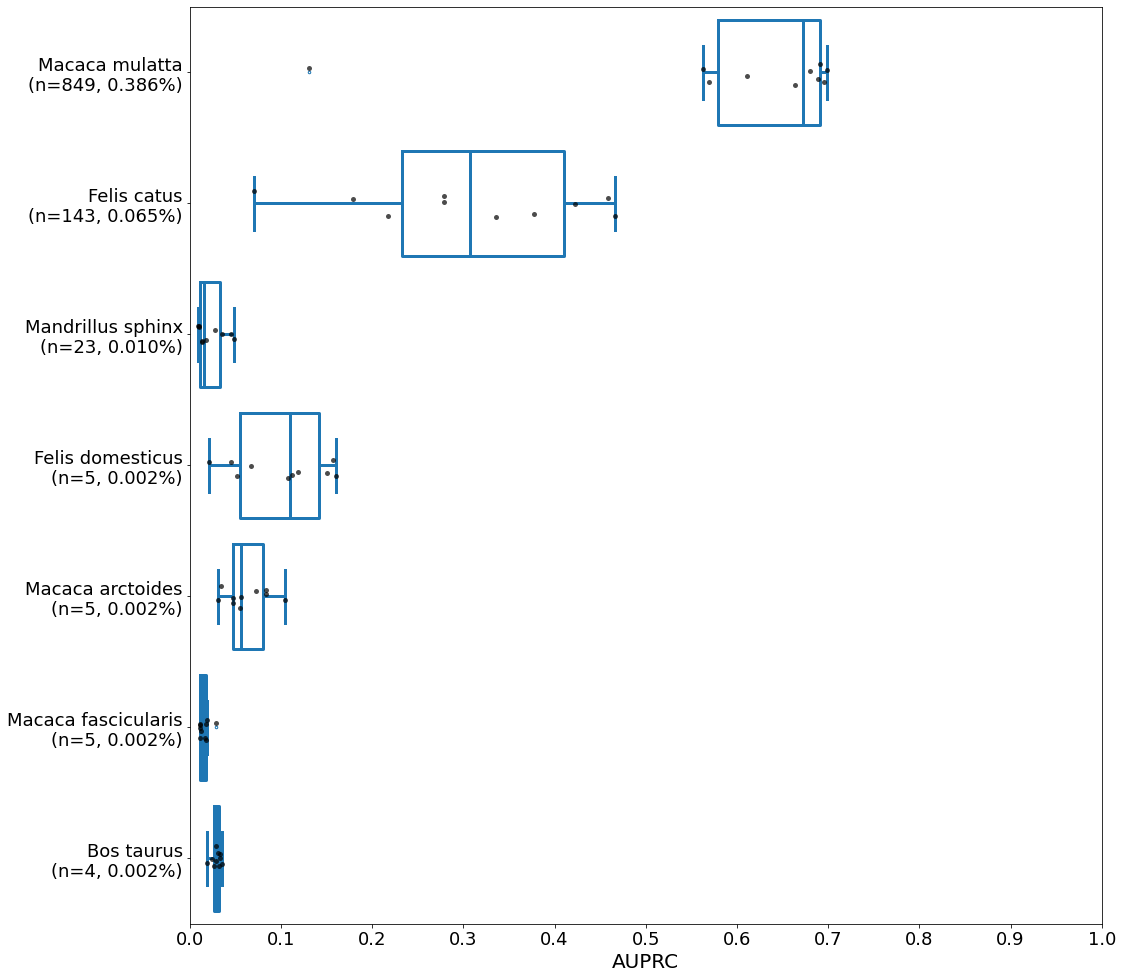

In [19]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(16, 14), sharex=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})



df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 1)
for i in range(1):
    #sns.violinplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h",  order=bins[i], fill=False,)
    sns.boxplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", linewidth=3, fill=False, fliersize=2.5, order=bins[i])
    sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", order=bins[i], color="black", alpha=.7, s=5)
    
    #sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs.set_ylabel("")
    axs.set_xlabel("AUPRC", fontsize=20)
    axs.set_xlim(0, 1)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    axs.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_w_non_idv_wo_human_classwise_boxplot.pdf"))
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

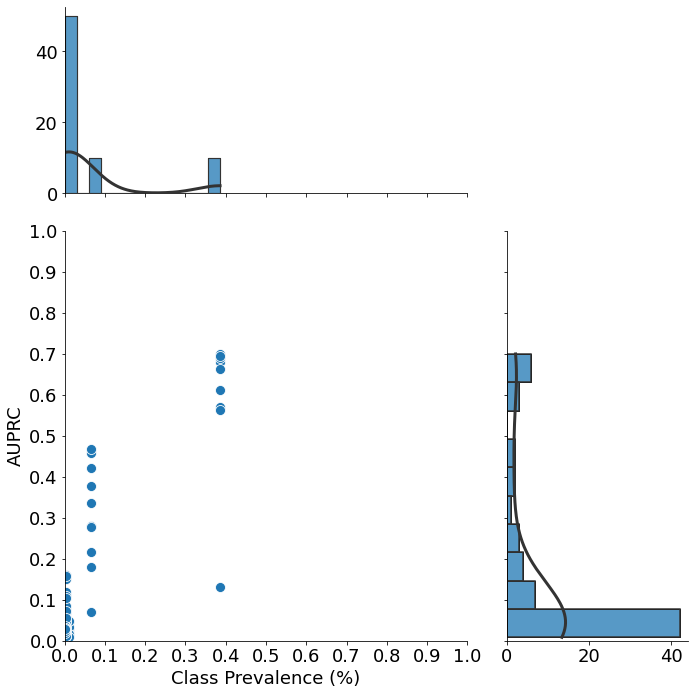

In [25]:
plt.clf()
plt.figure(figsize=(8,8))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams.update({'font.size': 18})

ax = sns.jointplot(data=df, x="prevalence", y="auprc",
                   height=10, ylim=(0, 1),  xlim=(0, 1),
                   ratio=2, legend=False, marginal_ticks=True)
ax.plot_joint(sns.scatterplot, alpha=1, s=100, legend=False)
ax.plot_marginals(sns.histplot, kde=True, fill=False, color="0.2", line_kws={"color": "black", "lw": 3, "ls": "-"})
# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
ax.ax_joint.set_xlabel("Class Prevalence (%)")
ax.ax_joint.set_ylabel("AUPRC")
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax = plt.gca()
#ax.legend()
ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_auprc_scatterplot_w_hist_20240924.pdf"))
plt.show()